In [ ]:
pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=ed04d2810f613eeb80f040e5f5b54a074d08dbc43e199102d85e344296b6e3be
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [ ]:
from medmnist import OrganAMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# some adjustable parameters
batch_size = 64

# load the training data
train_dataset = OrganAMNIST(split="train", download=True, transform=transforms.ToTensor())
train_dataset128 = OrganAMNIST(split="train", download=True, transform=transforms.ToTensor(), size=128)

# normalization

# mean and std for the training data
mean = 0.0
std = 0.0
nb_samples = 0
'''for image, _ in DataLoader(train_dataset, batch_size=1000):
    mean += image.mean()
    std += image.std()
mean /= len(train_dataset)
std /= len(train_dataset)'''

# create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64)

# batch means and stds need to be weighted by the batch size
for images, _ in train_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean([0, 2]) * batch_samples
    std += images.std([0, 2]) * batch_samples
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

# define the transform for normalization and to flatten the image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean.item()], std=[std.item()]),
    transforms.Lambda(lambda x: x.view(-1))  # flatten 28x28 image to 784 vector
])

# normalization 128

# mean and std for the training data
mean128 = 0.0
std128 = 0.0
for image, _ in DataLoader(train_dataset, batch_size=1000):
    mean128 += image.mean()
    std128 += image.std()
mean128 /= len(train_dataset)
std128 /= len(train_dataset)

# define the transform for normalization and to flatten the image
transform128 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean128, std128),
    transforms.Lambda(lambda x: x.view(-1))  # flatten
])

# load the training data with normalization
train_dataset = OrganAMNIST(split="train", download=True, transform=transform)
val_dataset = OrganAMNIST(split="val", download=True, transform=transform)
test_dataset = OrganAMNIST(split="test", download=True, transform=transform)

# create the data loader object
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# datasets for the 128px versions
train_dataset128 = OrganAMNIST(split="train", download=True, transform=transform128, size=128)
val_dataset128 = OrganAMNIST(split="val", download=True, transform=transform128, size=128)
test_dataset128 = OrganAMNIST(split="test", download=True, transform=transform128, size=128)

# create the data loader object
train_loader128 = DataLoader(train_dataset128, batch_size=batch_size, shuffle=True)
val_loader128 = DataLoader(val_dataset128, batch_size=batch_size, shuffle=True)
test_loader128 = DataLoader(test_dataset128, batch_size=batch_size, shuffle=True)


print("train", len(train_loader.dataset))
print("val", len(val_loader.dataset))
print("test", len(test_loader.dataset))


Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist_128.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist_128.npz
Using downloaded and verified file: /root/.medmnist/organamnist_128.npz
Using downloaded and verified file: /root/.medmnist/organamnist_128.npz
train 34561
val 6491
test 17778


# MLP Implimentation

Activation Functions

In [ ]:
def relu(x):
  return np.maximum(0, x)

def relu_d(x):
  return x > 0

def softmax(x):
  return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)


Helper Methods

In [ ]:
# function to initialize random weights and biases
def init_weights(D, M, C, num_hidden_layers):
  # calc number of weights and biases needed ...
  w = []
  b = []

  # init 1st layer's weights
  w.append(np.random.randn(D, M) * 0.01)
  b.append(np.random.randn(1, M) * 0.01)

  # init rest of layers
  for i in range(1, num_hidden_layers):
    print('loop')
    # create layer i weights
    w.append(np.random.randn(M, M) * 0.01)
    b.append(np.random.randn(1, M) * 0.01)

  # create the final output layer weights
  w.append(np.random.randn(M, C) * 0.01)
  b.append(np.random.randn(1, C) * 0.01)

  return w, b

# function to one hot encode labels
def one_hot(y):
  y_hot = np.zeros((y.size, 11))
  y_hot[np.arange(y.size), y] = 1
  return y_hot

# forward prop
def forward(x, w, b, activation_function):
  # create vectors for pre-activations, and activations
  z = []
  a = []

  # let z0 = none
  z.append(None)
  # let a0 = x
  a.append(x)

  for i in range(0, len(w)-1):
    # calc the pre-activation : z(i+1) = a(i) * w(i+1) + b(i+1)
    z.append(a[i].dot(w[i]) + b[i])

    # calc activation
    a.append(activation_function(z[i+1]))

  i+=1
  # calc the output layer
  z.append(a[i].dot(w[i]) + b[i])
  a.append(softmax(z[i+1]))

  # return the pre, and activations
  return z, a

# backward prop
def backward(x, y, z, a, w):
  # get dimentions
  N = y.size
  # one hot encode y
  y_hot = one_hot(y)

  # create gradient vector
  dw = [0] * len(w)
  db = [0] * len(w)
  dz = [0] * len(w)

  # get gradient of final layer
  dz[-1] = a[-1] - y_hot

  dw[-1] = a[-2].T.dot(dz[-1]) / N
  db[-1] = np.sum(dz[-1]) / N

  # get gradients of middle layers
  for i in range(len(w)-2, -1, -1):
    dz[i] = np.dot(dz[i+1], w[i+1].T) * relu_d(z[i+1])

    dw[i] = a[i].T.dot(dz[i]) / N
    db[i] = np.sum(dz[i]) / N

  return dw, db

# function to update the weight and biases
def update_weights(w, b, dw, db, lr):
  # update each weight and bias
  for i in range(0, len(w)):
    w[i] = w[i] - lr * dw[i]
    b[i] = b[i] - lr * db[i]

  # return updated weights and biases
  return w, b

# function to get the final prediction labels from the activation of the outer layer
def get_yh_from_activation(a):
  return np.argmax(a, 1)

# function to get the accuracy of the predictions
def eval_acc(model, dataset, w, b):
  correct = 0
  total = 0

  for x, y in dataset:
    x = x.numpy()
    y = y.flatten().numpy()

    # forward prop
    z, a = forward(x, w, b, relu)
    # get prediction classes
    yh = get_yh_from_activation(a[-1])

    total += len(yh)

    correct += (yh == y).sum().item()

  accuracy = correct / total * 100
  return accuracy

def compute_loss(model, dataset, w, b):
  loss = 0
  total = 0
  for x, y in dataset:
    x = x.numpy()
    y = y.flatten().numpy()

    # forward prop
    z, a = forward(x, w, b, relu)
    # get prediction classes
    yh = get_yh_from_activation(a[-1])

    total += len(yh)

    loss += y * np.log(yh + 1e-8)


  loss = -loss / total
  return loss


## MLP Class

In [ ]:
class MLP:
  def __init__(self, D=784, M=256, C=11, num_hidden_layers=1, af=relu):
    self.D = D
    self.M = M
    self.C = C
    self.num_hidden_layers = num_hidden_layers
    self.af = af
    self.history = {
        'loss': [],
        'train_acc': [],
        'val_acc': []
    }

  def fit(self, lr, epochs, train_loader=train_loader, val_loader=val_loader):
    # init weights
    #v, b1, w, b2 = init_weights(self.D, self.M, self.C, self.num_hidden_layers)
    w, b = init_weights(self.D, self.M, self.C, self.num_hidden_layers)

    # loop for # of epochs
    for i in range(0, epochs):
      y_true = []
      y_pred = []

      # loop over batches
      for x, y in tqdm(train_loader):
        # pre-process the data
        x = x.numpy()
        y = y.flatten().numpy()

        # forward pass
        z, a = forward(x, w, b, self.af)

        # backward pass
        dw, db = backward(x, y, z, a, w)

        # update weights
        w, b = update_weights(w, b, dw, db, lr)

        # build up lists for performance checker
        y_true.extend(y)
        y_pred.extend(get_yh_from_activation(a[-1]))

      # append progress to history
      self.history['loss'].append(compute_loss(self, train_loader, w, b))
      self.history['val_acc'].append(eval_acc(self, val_loader, w, b))
      self.history['train_acc'].append(eval_acc(self, train_loader, w, b))

      # print out progress
      print('epoch: ', i)
      print('train acc: ', self.history['train_acc'][-1])
      print('val acc: ', self.history['val_acc'][-1])

    # return learned weights
    self.w = w
    self.b = b
    return self

  def predict(self, dataset, w, b):
    y_true = []
    y_pred = []
    for x, y in dataset:
      # run forward pass
      z, a = forward(x, w, b, self.af)
      y_true.extend(y)
      y_pred.extend(np.argmax(a[-1], 1))

    # return y and yh
    return y_true, y_pred


# Hyper Parameter Tuning
I will find the best learning rate by trying a few options on a MLP model with 1 hidden layer. I will use the validation set to test the performance of the model on the different learning rates.

In [ ]:
model0 = MLP(num_hidden_layers=1)
model1 = MLP(num_hidden_layers=1)
model2 = MLP(num_hidden_layers=1)

model0.fit(lr=0.001, epochs=10)
model1.fit(lr=0.005, epochs=10)
model2.fit(lr=0.01, epochs=10)

100%|██████████| 541/541 [00:20<00:00, 26.98it/s]


epoch:  0
train acc:  36.312606695408114
val acc:  42.19688799876752


100%|██████████| 541/541 [00:16<00:00, 32.82it/s]


epoch:  1
train acc:  38.86172275107781
val acc:  44.36912648282237


100%|██████████| 541/541 [00:16<00:00, 32.55it/s]


epoch:  2
train acc:  47.721420097798095
val acc:  55.415190263441694


100%|██████████| 541/541 [00:16<00:00, 32.26it/s]


epoch:  3
train acc:  58.849570324932735
val acc:  69.18810660915113


100%|██████████| 541/541 [00:17<00:00, 31.39it/s]


epoch:  4
train acc:  64.62197274384421
val acc:  75.67401016792482


100%|██████████| 541/541 [00:16<00:00, 32.63it/s]


epoch:  5
train acc:  66.5229594051098
val acc:  78.73979356031428


100%|██████████| 541/541 [00:16<00:00, 33.14it/s]


epoch:  6
train acc:  67.94074245536876
val acc:  79.87983361577568


100%|██████████| 541/541 [00:18<00:00, 29.60it/s]


epoch:  7
train acc:  69.61314776771505
val acc:  81.42042828531814


100%|██████████| 541/541 [00:16<00:00, 32.73it/s]


epoch:  8
train acc:  70.79656259946182
val acc:  82.42181482052072


100%|██████████| 541/541 [00:16<00:00, 32.51it/s]


epoch:  9
train acc:  71.60093747287405
val acc:  83.31535972885534


100%|██████████| 541/541 [00:18<00:00, 29.14it/s]


epoch:  0
train acc:  59.68866641590231
val acc:  71.49899861346479


100%|██████████| 541/541 [00:16<00:00, 32.33it/s]


epoch:  1
train acc:  71.95393651804056
val acc:  84.65567709135726


100%|██████████| 541/541 [00:16<00:00, 32.72it/s]


epoch:  2
train acc:  73.4816700905645
val acc:  84.25512247727623


100%|██████████| 541/541 [00:16<00:00, 32.09it/s]


epoch:  3
train acc:  70.73001359914355
val acc:  80.4498536435064


100%|██████████| 541/541 [00:18<00:00, 29.69it/s]


epoch:  4
train acc:  78.4265501576922
val acc:  89.12340163303035


100%|██████████| 541/541 [00:16<00:00, 32.34it/s]


epoch:  5
train acc:  77.10425045571598
val acc:  86.27330149437682


100%|██████████| 541/541 [00:16<00:00, 32.39it/s]


epoch:  6
train acc:  68.17221723908452
val acc:  77.4919118779849


100%|██████████| 541/541 [00:18<00:00, 28.66it/s]


epoch:  7
train acc:  80.55611816787709
val acc:  90.14019411492836


100%|██████████| 541/541 [00:16<00:00, 32.01it/s]


epoch:  8
train acc:  82.77538265675183
val acc:  90.87967955630873


100%|██████████| 541/541 [00:16<00:00, 32.27it/s]


epoch:  9
train acc:  83.17178322386505
val acc:  90.58696656909568


100%|██████████| 541/541 [00:18<00:00, 29.79it/s]


epoch:  0
train acc:  71.20164347096438
val acc:  81.91341857957171


100%|██████████| 541/541 [00:17<00:00, 31.35it/s]


epoch:  1
train acc:  76.18124475564943
val acc:  87.61361885687874


100%|██████████| 541/541 [00:16<00:00, 32.07it/s]


epoch:  2
train acc:  78.61462341946124
val acc:  88.35310429825913


100%|██████████| 541/541 [00:17<00:00, 31.02it/s]


epoch:  3
train acc:  72.62810682561268
val acc:  79.29440764134957


100%|██████████| 541/541 [00:17<00:00, 31.29it/s]


epoch:  4
train acc:  83.71574896559706
val acc:  91.15698659682637


100%|██████████| 541/541 [00:17<00:00, 31.73it/s]


epoch:  5
train acc:  79.21935129191864
val acc:  88.56878755199506


100%|██████████| 541/541 [00:17<00:00, 31.01it/s]


epoch:  6
train acc:  86.02760336795811
val acc:  91.3572639038669


100%|██████████| 541/541 [00:17<00:00, 31.54it/s]


epoch:  7
train acc:  86.79725702381297
val acc:  90.83346171622246


100%|██████████| 541/541 [00:16<00:00, 32.86it/s]


epoch:  8
train acc:  88.34813807470849
val acc:  90.8642736096133


100%|██████████| 541/541 [00:17<00:00, 31.44it/s]


epoch:  9
train acc:  80.7846995167964
val acc:  89.12340163303035


#plot the results

train accuracy

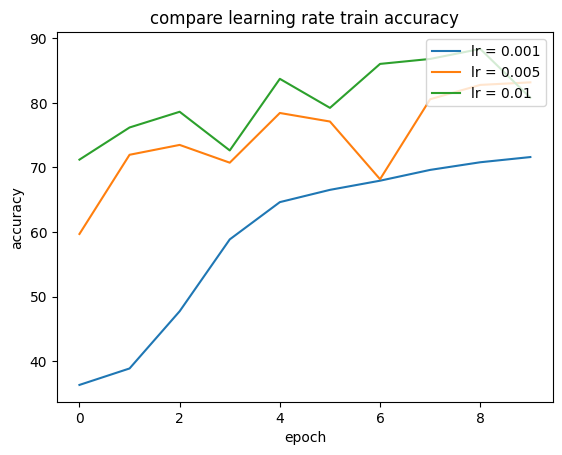

final train accuracy for lr = 0.001:  71.60093747287405
final train accuracy for lr = 0.005:  83.17178322386505
final train accuracy for lr = 0.01:  80.7846995167964


In [ ]:
plt.plot(model0.history['train_acc'])
plt.plot(model1.history['train_acc'])
plt.plot(model2.history['train_acc'])
plt.title('compare learning rate train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['lr = 0.001', 'lr = 0.005', 'lr = 0.01'], loc='upper right')

plt.show()

print("final train accuracy for lr = 0.001: ", model0.history['train_acc'][-1])
print("final train accuracy for lr = 0.005: ", model1.history['train_acc'][-1])
print("final train accuracy for lr = 0.01: ", model2.history['train_acc'][-1])

validation accuracy

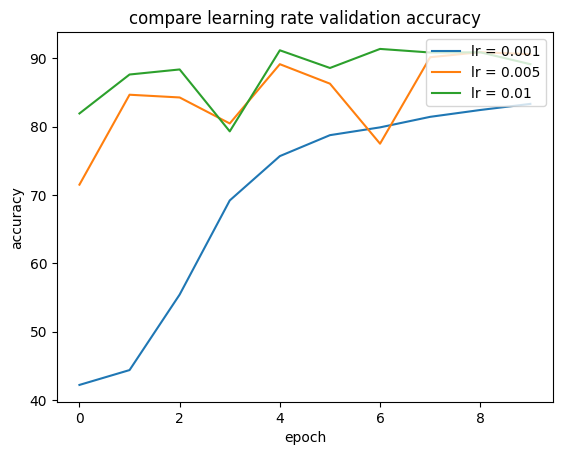

final validation accuracy for lr = 0.001:  83.31535972885534
final validation accuracy for lr = 0.005:  90.58696656909568
final validation accuracy for lr = 0.01:  89.12340163303035


In [ ]:
plt.plot(model0.history['val_acc'])
plt.plot(model1.history['val_acc'])
plt.plot(model2.history['val_acc'])
plt.title('compare learning rate validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['lr = 0.001', 'lr = 0.005', 'lr = 0.01'], loc='upper right')

plt.show()

print("final validation accuracy for lr = 0.001: ", model0.history['val_acc'][-1])
print("final validation accuracy for lr = 0.005: ", model1.history['val_acc'][-1])
print("final validation accuracy for lr = 0.01: ", model2.history['val_acc'][-1])

loss

As seen in the plots, the model with lr = 0.005 performed the best, so going forward I will be using a lr of 0.005

# Experiment 1
create 3 models with 0, 1 and 2 hidden layers respectivly.

In [ ]:
# create 3 models:
model0 = MLP(num_hidden_layers=0)
model1 = MLP(num_hidden_layers=1)
model2 = MLP(num_hidden_layers=2)

# train the models
model0.fit(lr=0.005, epochs=25)
model1.fit(lr=0.005, epochs=25)
model2.fit(lr=0.005, epochs=25)




100%|██████████| 541/541 [00:16<00:00, 32.31it/s]


epoch:  0
train acc:  56.52324874858945
val acc:  67.77075951317208


100%|██████████| 541/541 [00:16<00:00, 32.41it/s]


epoch:  1
train acc:  70.24970342293337
val acc:  82.63749807425667


100%|██████████| 541/541 [00:18<00:00, 29.33it/s]


epoch:  2
train acc:  73.32253117675992
val acc:  84.33215221075335


100%|██████████| 541/541 [00:16<00:00, 32.65it/s]


epoch:  3
train acc:  75.18879662046815
val acc:  86.72007394854414


100%|██████████| 541/541 [00:16<00:00, 32.35it/s]


epoch:  4
train acc:  78.07065767772923
val acc:  88.784470805731


100%|██████████| 541/541 [00:16<00:00, 32.64it/s]


epoch:  5
train acc:  76.11180232053471
val acc:  86.42736096133108


100%|██████████| 541/541 [00:18<00:00, 29.36it/s]


epoch:  6
train acc:  76.81201354127485
val acc:  85.65706362655985


100%|██████████| 541/541 [00:16<00:00, 32.72it/s]


epoch:  7
train acc:  81.80897543473857
val acc:  90.925897396395


100%|██████████| 541/541 [00:16<00:00, 32.26it/s]


epoch:  8
train acc:  82.34715430687768
val acc:  90.64859035587737


100%|██████████| 541/541 [00:17<00:00, 30.76it/s]


epoch:  9
train acc:  82.52365382946095
val acc:  90.43290710214143


100%|██████████| 541/541 [00:16<00:00, 32.11it/s]


epoch:  10
train acc:  83.34249587685541
val acc:  90.417501155446


100%|██████████| 541/541 [00:16<00:00, 33.00it/s]


epoch:  11
train acc:  84.32626370764736
val acc:  90.83346171622246


100%|██████████| 541/541 [00:16<00:00, 33.17it/s]


epoch:  12
train acc:  84.47961575185903
val acc:  91.1723925435218


100%|██████████| 541/541 [00:16<00:00, 32.53it/s]


epoch:  13
train acc:  86.08836549868349
val acc:  91.2340163303035


100%|██████████| 541/541 [00:18<00:00, 29.94it/s]


epoch:  14
train acc:  86.8609125893348
val acc:  91.43429363734401


100%|██████████| 541/541 [00:16<00:00, 32.93it/s]


epoch:  15
train acc:  87.06923989467897
val acc:  90.925897396395


100%|██████████| 541/541 [00:16<00:00, 32.47it/s]


epoch:  16
train acc:  88.01828650791354
val acc:  91.32645201047605


100%|██████████| 541/541 [00:16<00:00, 32.53it/s]


epoch:  17
train acc:  88.14270420416076
val acc:  90.61777846248653


100%|██████████| 541/541 [00:17<00:00, 31.48it/s]


epoch:  18
train acc:  83.15442261508636
val acc:  85.36435063934678


100%|██████████| 541/541 [00:17<00:00, 31.71it/s]


epoch:  19
train acc:  89.74856051618877
val acc:  91.1723925435218


100%|██████████| 541/541 [00:16<00:00, 32.84it/s]


epoch:  20
train acc:  89.97424843031162
val acc:  90.69480819596365


100%|██████████| 541/541 [00:16<00:00, 32.32it/s]


epoch:  21
train acc:  90.66867278145887
val acc:  91.20320443691264


100%|██████████| 541/541 [00:16<00:00, 32.57it/s]


epoch:  22
train acc:  90.71496773820202
val acc:  90.925897396395


100%|██████████| 541/541 [00:17<00:00, 30.69it/s]


epoch:  23
train acc:  90.23176412719539
val acc:  91.1723925435218


100%|██████████| 541/541 [00:16<00:00, 32.55it/s]


epoch:  24
train acc:  83.57975753016406
val acc:  81.18933908488677


100%|██████████| 541/541 [00:16<00:00, 32.52it/s]


epoch:  0
train acc:  60.06191950464397
val acc:  70.22030503774457


100%|██████████| 541/541 [00:16<00:00, 32.92it/s]


epoch:  1
train acc:  70.84575099100142
val acc:  81.8363888460946


100%|██████████| 541/541 [00:18<00:00, 29.74it/s]


epoch:  2
train acc:  71.1350944706461
val acc:  80.01848713603451


100%|██████████| 541/541 [00:16<00:00, 32.64it/s]


epoch:  3
train acc:  74.89655970602702
val acc:  84.70189493144353


100%|██████████| 541/541 [00:16<00:00, 32.32it/s]


epoch:  4
train acc:  78.14588698243685
val acc:  88.83068864581729


100%|██████████| 541/541 [00:16<00:00, 33.11it/s]


epoch:  5
train acc:  79.08625329128208
val acc:  89.07718379294408


100%|██████████| 541/541 [00:18<00:00, 29.00it/s]


epoch:  6
train acc:  79.69676803333236
val acc:  89.20043136650747


100%|██████████| 541/541 [00:16<00:00, 32.68it/s]


epoch:  7
train acc:  80.50403634154104
val acc:  90.14019411492836


100%|██████████| 541/541 [00:16<00:00, 33.30it/s]


epoch:  8
train acc:  82.10410578397615
val acc:  90.37128331535973


100%|██████████| 541/541 [00:16<00:00, 32.52it/s]


epoch:  9
train acc:  82.4715720031249
val acc:  90.50993683561856


100%|██████████| 541/541 [00:17<00:00, 30.20it/s]


epoch:  10
train acc:  82.86797257023812
val acc:  90.94130334309042


100%|██████████| 541/541 [00:16<00:00, 33.10it/s]


epoch:  11
train acc:  84.88759005815804
val acc:  91.34185795717147


100%|██████████| 541/541 [00:16<00:00, 32.95it/s]


epoch:  12
train acc:  83.11680796273257
val acc:  89.23124325989832


100%|██████████| 541/541 [00:16<00:00, 32.63it/s]


epoch:  13
train acc:  85.68039119238448
val acc:  91.18779849021722


100%|██████████| 541/541 [00:16<00:00, 32.52it/s]


epoch:  14
train acc:  86.65837215358351
val acc:  91.2956401170852


100%|██████████| 541/541 [00:18<00:00, 29.75it/s]


epoch:  15
train acc:  87.40487833106681
val acc:  91.52672931751657


100%|██████████| 541/541 [00:16<00:00, 32.67it/s]


epoch:  16
train acc:  88.00092589913487
val acc:  91.2956401170852


100%|██████████| 541/541 [00:16<00:00, 32.53it/s]


epoch:  17
train acc:  87.78970515899425
val acc:  91.24942227699893


100%|██████████| 541/541 [00:16<00:00, 32.53it/s]


epoch:  18
train acc:  88.88342351205115
val acc:  91.07995686334925


100%|██████████| 541/541 [00:18<00:00, 29.49it/s]


epoch:  19
train acc:  84.80368044906108
val acc:  86.65845016176243


100%|██████████| 541/541 [00:16<00:00, 31.99it/s]


epoch:  20
train acc:  89.27693064436792
val acc:  91.38807579725774


100%|██████████| 541/541 [00:16<00:00, 32.37it/s]


epoch:  21
train acc:  86.81461763259165
val acc:  87.259282082884


100%|██████████| 541/541 [00:16<00:00, 31.95it/s]


epoch:  22
train acc:  90.92618847834264
val acc:  91.07995686334925


100%|██████████| 541/541 [00:18<00:00, 29.78it/s]


epoch:  23
train acc:  91.54538352478227
val acc:  90.98752118317671


100%|██████████| 541/541 [00:16<00:00, 31.89it/s]


epoch:  24
train acc:  91.46436735048175
val acc:  91.20320443691264
loop


100%|██████████| 541/541 [00:17<00:00, 30.12it/s]


epoch:  0
train acc:  30.470761841381904
val acc:  31.82868587274688


100%|██████████| 541/541 [00:19<00:00, 28.42it/s]


epoch:  1
train acc:  41.50921558982668
val acc:  44.769681096903405


100%|██████████| 541/541 [00:18<00:00, 29.39it/s]


epoch:  2
train acc:  52.35091577211307
val acc:  59.15883531042982


100%|██████████| 541/541 [00:21<00:00, 25.02it/s]


epoch:  3
train acc:  62.064176383785195
val acc:  72.56200893544909


100%|██████████| 541/541 [00:18<00:00, 29.71it/s]


epoch:  4
train acc:  64.06353982812998
val acc:  75.95131720844246


100%|██████████| 541/541 [00:17<00:00, 30.09it/s]


epoch:  5
train acc:  69.51187754983941
val acc:  78.07733785241103


100%|██████████| 541/541 [00:16<00:00, 31.97it/s]


epoch:  6
train acc:  73.82888226613812
val acc:  83.88537975658605


100%|██████████| 541/541 [00:18<00:00, 29.56it/s]


epoch:  7
train acc:  75.77037701455399
val acc:  85.88815282699122


100%|██████████| 541/541 [00:18<00:00, 29.56it/s]


epoch:  8
train acc:  77.5006510228292
val acc:  88.15282699121862


100%|██████████| 541/541 [00:20<00:00, 26.83it/s]


epoch:  9
train acc:  78.62619715864703
val acc:  87.99876752426437


100%|██████████| 541/541 [00:19<00:00, 27.84it/s]


epoch:  10
train acc:  79.9022019038801
val acc:  89.53936219380681


100%|██████████| 541/541 [00:18<00:00, 29.92it/s]


epoch:  11
train acc:  80.87150256068979
val acc:  89.77045139423817


100%|██████████| 541/541 [00:19<00:00, 28.31it/s]


epoch:  12
train acc:  81.78004108677412
val acc:  90.14019411492836


100%|██████████| 541/541 [00:17<00:00, 30.79it/s]


epoch:  13
train acc:  82.54101443823963
val acc:  90.64859035587737


100%|██████████| 541/541 [00:17<00:00, 30.95it/s]


epoch:  14
train acc:  83.86331414021585
val acc:  91.1107687567401


100%|██████████| 541/541 [00:17<00:00, 30.69it/s]


epoch:  15
train acc:  83.0271114840427
val acc:  89.26205515328917


100%|██████████| 541/541 [00:16<00:00, 31.94it/s]


epoch:  16
train acc:  79.11518763924656
val acc:  86.36573717454937


100%|██████████| 541/541 [00:17<00:00, 30.48it/s]


epoch:  17
train acc:  74.39599548624172
val acc:  82.20613156678478


100%|██████████| 541/541 [00:17<00:00, 30.97it/s]


epoch:  18
train acc:  86.00156245479008
val acc:  89.41611462024342


100%|██████████| 541/541 [00:21<00:00, 25.15it/s]


epoch:  19
train acc:  87.96909811637394
val acc:  91.20320443691264


100%|██████████| 541/541 [00:17<00:00, 31.64it/s]


epoch:  20
train acc:  88.73875177222881
val acc:  91.40348174395317


100%|██████████| 541/541 [00:17<00:00, 30.91it/s]


epoch:  21
train acc:  89.43028268857961
val acc:  91.37266985056232


100%|██████████| 541/541 [00:18<00:00, 29.41it/s]


epoch:  22
train acc:  90.21151008362025
val acc:  90.98752118317671


100%|██████████| 541/541 [00:18<00:00, 29.55it/s]


epoch:  23
train acc:  88.09351581262116
val acc:  89.35449083346172


100%|██████████| 541/541 [00:21<00:00, 25.44it/s]


epoch:  24
train acc:  91.56853100315384
val acc:  91.21861038360807


Plot the results

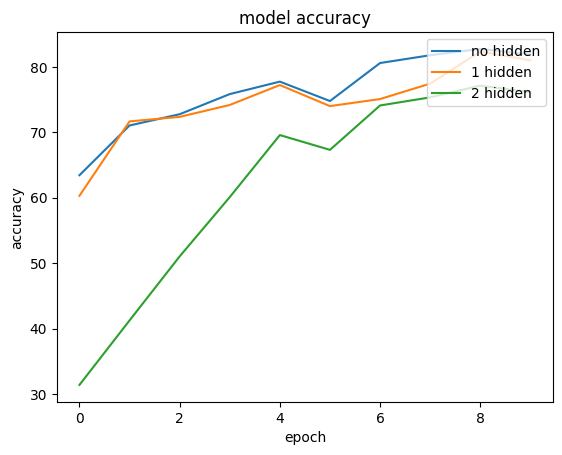

In [ ]:
plt.plot(model0.history['train_acc'])
plt.plot(model1.history['train_acc'])
plt.plot(model2.history['train_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['no hidden', '1 hidden', '2 hidden'], loc='upper right')